In [161]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score)
import seaborn as sns
from statsmodels.gam.api import GLMGam, BSplines
import statsmodels.api as sm
from statsmodels.gam.tests.test_penalized import df_autos

In [141]:
dfAll = pd.read_csv('train.csv')
df = dfAll[dfAll.stock_id == 2]

In [142]:
dfUse = df.copy()
dropping = ['stock_id', 'time_id', 'date_id', 'seconds_in_bucket']
dfUse.sort_index(level=['date_id', 'time_id'], inplace=True)
dfUse.drop(dropping, inplace=True, axis=1)
dfUse.set_index('row_id', inplace=True)
dfUse.fillna(0, inplace=True)

In [207]:
dfUse.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26455 entries, 0_0_2 to 480_540_2
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   imbalance_size           26455 non-null  float64
 1   imbalance_buy_sell_flag  26455 non-null  int64  
 2   reference_price          26455 non-null  float64
 3   matched_size             26455 non-null  float64
 4   far_price                26455 non-null  float64
 5   near_price               26455 non-null  float64
 6   bid_price                26455 non-null  float64
 7   bid_size                 26455 non-null  float64
 8   ask_price                26455 non-null  float64
 9   ask_size                 26455 non-null  float64
 10  wap                      26455 non-null  float64
 11  target                   26455 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 3.6+ MB


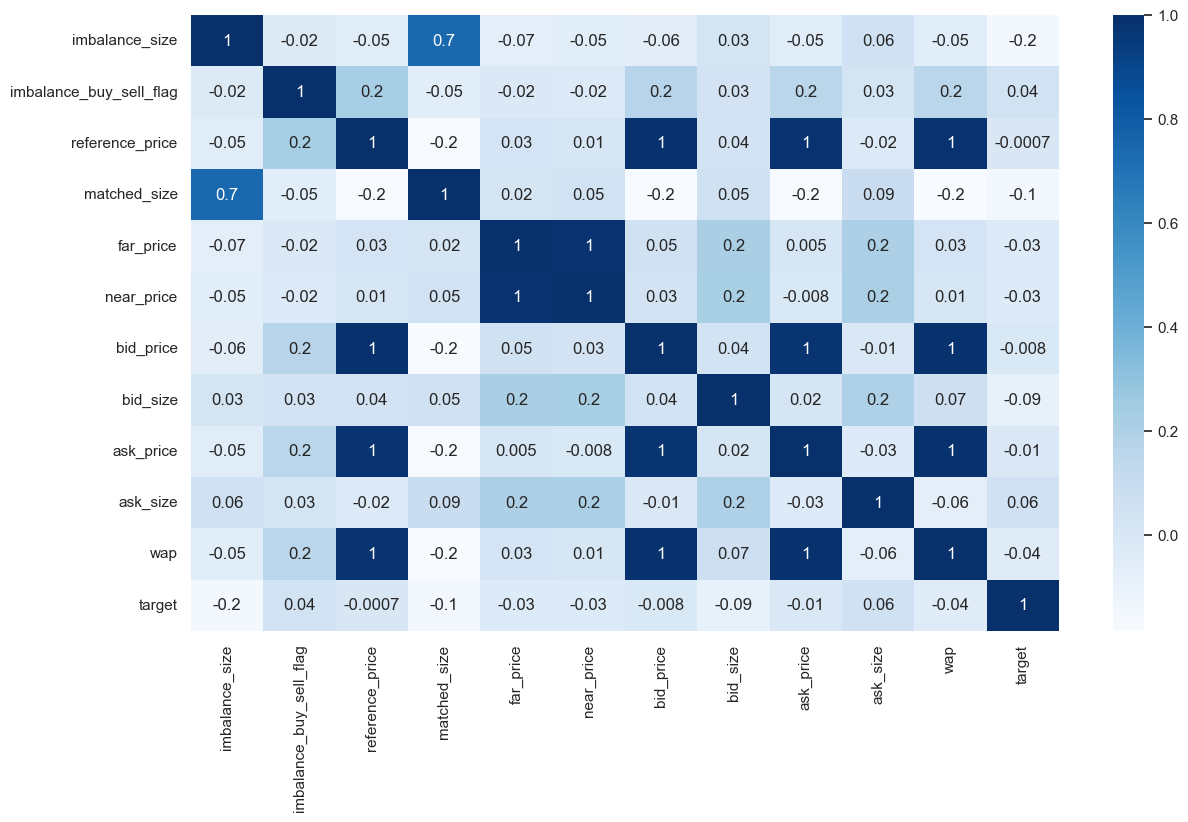

In [144]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
dfCorr = dfUse.corr()
heatmap = sns.heatmap(dfCorr, annot=True, cmap="Blues", fmt='.1g')

In [146]:
dfUse.describe()

,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
count,2.645500e+04,26455.000000,26455.000000,2.645500e+04,26455.000000,26455.000000,26455.000000,2.645500e+04,26455.000000,2.645500e+04,26455.000000,26455.000000
mean,1.866116e+06,0.046985,1.000149,9.895372e+06,0.447097,0.454680,0.999697,2.360035e+04,1.000608,2.581968e+04,1.000145,0.025008
std,1.612834e+07,0.827912,0.002714,5.605824e+07,0.498017,0.498140,0.002670,3.544421e+04,0.002663,4.023044e+04,0.002677,10.979600
min,0.000000e+00,-1.000000,0.966012,5.651996e+05,0.000000,0.000000,0.965748,8.399000e+01,0.967765,8.380000e+01,0.967298,-170.210000
25%,0.000000e+00,-1.000000,0.998731,2.400914e+06,0.000000,0.000000,0.998367,2.806205e+03,0.999248,2.895050e+03,0.998759,-5.795062
50%,3.204967e+05,0.000000,1.000118,3.980605e+06,0.000000,0.000000,0.999680,1.238910e+04,1.000520,1.383900e+04,1.000053,-0.079870
75%,1.199834e+06,1.000000,1.001498,6.496791e+06,0.999655,0.999725,1.001024,3.024917e+04,1.001950,3.392410e+04,1.001467,5.865097
max,6.195607e+08,1.000000,1.021975,1.494537e+09,1.353206,1.098223,1.019387,1.069922e+06,1.022605,1.733813e+06,1.021742,103.969574


In [241]:
dfScaling = dfUse.copy()
# df.drop('Adj Close', inplace=True)
# X = dfScaling.drop('target', axis=1)
X = dfScaling.drop(['target', 'imbalance_buy_sell_flag', 'far_price', 'near_price', 'bid_size', 'ask_size'], axis=1)
y = dfScaling['target']

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
X = sc.fit_transform(X)
# training_set_scaled = np.concatenate((np.array(y.values), X), axis=1)
# training_set_scaled = np.hstack([y, X])
training_set_scaled = pd.DataFrame(np.hstack((X, np.array(y.values).reshape(-1, 1))), columns=dfUse.columns)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.005, shuffle=False)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.005, shuffle=True)

ValueError: Shape of passed values is (26455, 7), indices imply (26455, 12)

In [ ]:
training_set_scaled.columns

In [ ]:
# df.drop('Adj Close', inplace=True)
X = training_set_scaled.drop(['target', 'imbalance_buy_sell_flag', 'far_price', 'near_price', 'bid_size', 'ask_size'], axis=1)
y = training_set_scaled['target']

In [ ]:
# X_ = sm.add_constant(X)
smMod = sm.OLS(y, X)
# smMod = sm.OLS('target ~ imbalance_size + imbalance_buy_sell_flag + reference_price + matched_size + far_price + near_price + \
#                 bid_price + bid_size + ask_price + ask_size + wap', data=training_set_scaled)
res = smMod.fit()
print(res.summary())

In [229]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
# reg.score(X_test, y_test)
lin_pred = reg.predict(X_test)

lin_mse = mean_squared_error(y_test, lin_pred)
lin_mae = mean_absolute_error(y_test, lin_pred)
lin_r2 = r2_score(y_test, lin_pred)
print(f'Mean Squared Error (MSE): {lin_mse}')
print(f'Mean Absolute Error (MAE): {lin_mae}')
print(f'R-squared (R2): {lin_r2}')

Mean Squared Error (MSE): 110.42705687033757
Mean Absolute Error (MAE): 8.08668264055596
R-squared (R2): 0.03433329272619012


In [230]:
from sklearn.linear_model import Ridge
rid = Ridge(alpha=0.000000001).fit(X_train, y_train)
rid_pred = rid.predict(X_test)

rid_mse = mean_squared_error(y_test, rid_pred)
rid_mae = mean_absolute_error(y_test, rid_pred)
rid_r2 = r2_score(y_test, rid_pred)
print(f'Mean Squared Error (MSE): {rid_mse}')
print(f'Mean Absolute Error (MAE): {rid_mae}')
print(f'R-squared (R2): {rid_r2}')

Mean Squared Error (MSE): 110.42705686111219
Mean Absolute Error (MAE): 8.086682640409103
R-squared (R2): 0.03433329280686448


In [231]:
from sklearn import linear_model
lass = linear_model.Lasso(alpha=0.0001, max_iter=10000000).fit(X_train, y_train)
lass_pred = lass.predict(X_test)

lass_mse = mean_squared_error(y_test, lass_pred)
lass_mae = mean_absolute_error(y_test, lass_pred)
lass_r2 = r2_score(y_test, lass_pred)
print(f'Mean Squared Error (MSE): {lass_mse}')
print(f'Mean Absolute Error (MAE): {lass_mae}')
print(f'R-squared (R2): {lass_r2}')

Mean Squared Error (MSE): 110.33209657183274
Mean Absolute Error (MAE): 8.08589404775372
R-squared (R2): 0.03516370513939571


In [232]:
from sklearn.linear_model import ElasticNet
# from sklearn.datasets import make_regression
# X_train, y_train = make_regression(n_features=60, random_state=0)
regElc = ElasticNet(alpha=0.0001, l1_ratio=0.9, max_iter=10000000).fit(X_train, y_train)
elc_pred = regElc.predict(X_test)

elc_mse = mean_squared_error(y_test, elc_pred)
elc_mae = mean_absolute_error(y_test, elc_pred)
elc_r2 = r2_score(y_test, elc_pred)
print(f'Mean Squared Error (MSE): {elc_mse}')
print(f'Mean Absolute Error (MAE): {elc_mae}')
print(f'R-squared (R2): {elc_r2}')

Mean Squared Error (MSE): 109.25055136977903
Mean Absolute Error (MAE): 8.076177600325638
R-squared (R2): 0.04462164256555867


In [233]:
from sklearn.linear_model import BayesianRidge
# bay_ridge = BayesianRidge(alpha_1=100, alpha_2=10, lambda_1=200, lambda_2=200).fit(X_train, y_train)
bay_ridge = BayesianRidge().fit(X_train, y_train)
bay_pred = bay_ridge.predict(X_test)

bay_mse = mean_squared_error(y_test, bay_pred)
bay_mae = mean_absolute_error(y_test, bay_pred)
bay_r2 = r2_score(y_test, bay_pred)
print(f'Mean Squared Error (MSE): {bay_mse}')
print(f'Mean Absolute Error (MAE): {bay_mae}')
print(f'R-squared (R2): {bay_r2}')

Mean Squared Error (MSE): 110.38392740571841
Mean Absolute Error (MAE): 8.085989629660999
R-squared (R2): 0.03471045290111141


In [234]:
from xgboost import XGBRegressor
xgb = XGBRegressor().fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)
print(f'Mean Squared Error (MSE): {xgb_mse}')
print(f'Mean Absolute Error (MAE): {xgb_mae}')
print(f'R-squared (R2): {xgb_r2}')

Mean Squared Error (MSE): 92.38833185798829
Mean Absolute Error (MAE): 7.317984888024597
R-squared (R2): 0.19207901809263472


In [240]:
from sklearn.svm import SVR
# regSVR = SVR(C=1, epsilon=0.1).fit(X_train, y_train) 
regSVR = SVR().fit(X_train, y_train) 
SVR_pred = regSVR.predict(X_test)

SVR_mse = mean_squared_error(y_test, SVR_pred)
SVR_mae = mean_absolute_error(y_test, SVR_pred)
SVR_r2 = r2_score(y_test, SVR_pred)
print(f'Mean Squared Error (MSE): {SVR_mse}')
print(f'Mean Absolute Error (MAE): {SVR_mae}')
print(f'R-squared (R2): {SVR_r2}')

Mean Squared Error (MSE): 111.41481836264967
Mean Absolute Error (MAE): 8.146726606010418
R-squared (R2): 0.025695478635274882


In [236]:
from sklearn.tree import DecisionTreeRegressor
# regTree = DecisionTreeRegressor(max_depth=10, min_samples_split=10, min_samples_leaf=10).fit(X_train, y_train)
regTree = DecisionTreeRegressor().fit(X_train, y_train)
tree_pred = regTree.predict(X_test)

tree_mse = mean_squared_error(y_test, tree_pred)
tree_mae = mean_absolute_error(y_test, tree_pred)
tree_r2 = r2_score(y_test, tree_pred)
print(f'Mean Squared Error (MSE): {tree_mse}')
print(f'Mean Absolute Error (MAE): {tree_mae}')
print(f'R-squared (R2): {tree_r2}')

Mean Squared Error (MSE): 110.76387104200086
Mean Absolute Error (MAE): 7.823118547518799
R-squared (R2): 0.03138790740730801


In [237]:
from sklearn.preprocessing import PolynomialFeatures
polyX_train = PolynomialFeatures(degree=2, interaction_only=True, include_bias=True).fit_transform(X_train) #include_bias=True, interaction_only=False 
polyReg = LinearRegression().fit(polyX_train, y_train)
polyX_test = PolynomialFeatures(degree=2, interaction_only=True, include_bias=True).fit_transform(X_test) #include_bias=True, interaction_only=False 
poly_pred = polyReg.predict(polyX_test)

poly_mse = mean_squared_error(y_test, poly_pred)
poly_mae = mean_absolute_error(y_test, poly_pred)
poly_r2 = r2_score(y_test, poly_pred)
print(f'Mean Squared Error (MSE): {poly_mse}')
print(f'Mean Absolute Error (MAE): {poly_mae}')
print(f'R-squared (R2): {poly_r2}')

Mean Squared Error (MSE): 113.28362854136503
Mean Absolute Error (MAE): 8.203399768537679
R-squared (R2): 0.00935303663830267


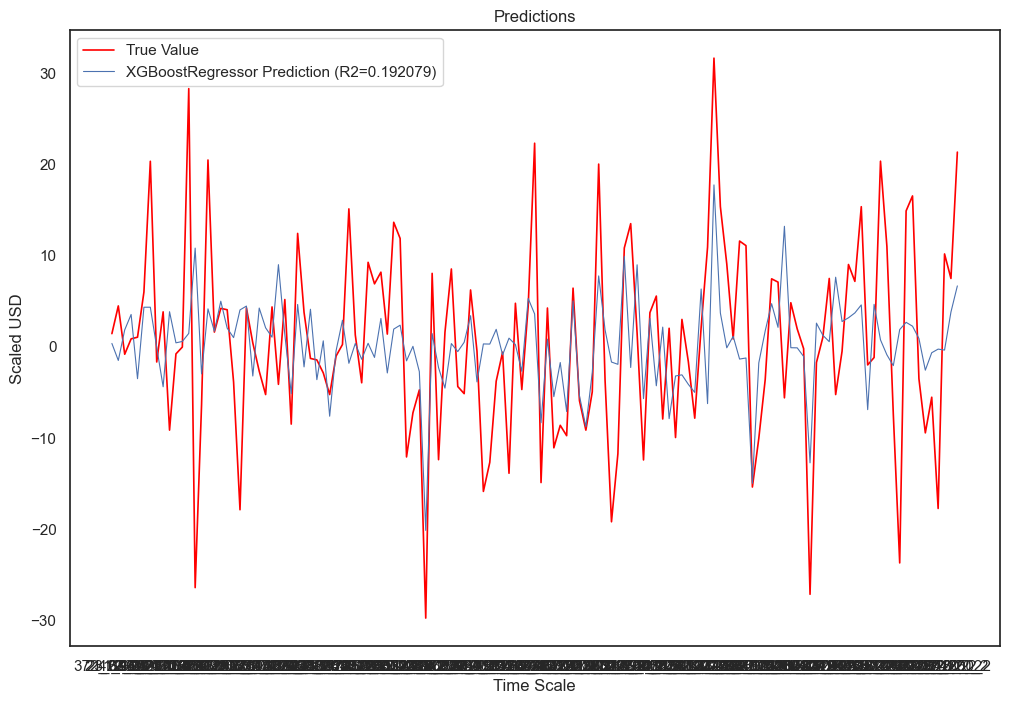

In [239]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True Value', color='red', linewidth=1.2)
# plt.plot(lin_pred, label=f'Linear Prediction (R2={lin_r2:.6f})', linewidth=0.8)
# plt.plot(rid_pred, label=f'Ridge Prediction (R2={rid_r2:.6f})', linewidth=0.8)
# plt.plot(lass_pred, label=f'Lasso Prediction (R2={lass_r2:.6f})', linewidth=0.8)
# plt.plot(elc_pred, label=f'ElasticNet Prediction (R2={elc_r2:.6f})', linewidth=0.8)

# plt.plot(tree_pred, label=f'DecisionTree Prediction (R2={tree_r2:.6f})', linewidth=0.8)
# plt.plot(SVR_pred, label=f'SVR Prediction (R2={SVR_r2:.6f})', linewidth=0.8)

# plt.plot(bay_pred, label=f'Bayesian_Ridge Prediction (R2={bay_r2:.6f})', linewidth=0.8)

plt.plot(xgb_pred, label=f'XGBoostRegressor Prediction (R2={xgb_r2:.6f})', linewidth=0.8) 
# plt.plot(poly_pred, label=f'PolyLinReg Prediction (R2={poly_r2:.6f})', linewidth=0.8) 
plt.title('Predictions')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()